In [1]:
from pymongo import MongoClient
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt

In [ ]:
# Connect to MongoDB
client = MongoClient("mongodb+srv://admin:<mypassword>@cluster0.jwzyj.mongodb.net/?ssl=true")
db = client["hotel_guests"]
collection = db["dining_info"]

In [3]:
# Load Data
df = pd.DataFrame(list(collection.find()))

In [4]:
# Convert to DateTime Format
df['check_in_date'] = pd.to_datetime(df['check_in_date'])
df['check_out_date'] = pd.to_datetime(df['check_out_date'])
df['order_time'] = pd.to_datetime(df['order_time'])

In [5]:
# Feature Engineering
df['order_hour'] = df['order_time'].dt.hour
df['is_weekend'] = (df['order_time'].dt.dayofweek >= 5).astype(int)
df['stay_duration'] = (df['check_out_date'] - df['check_in_date']).dt.days

In [6]:
# Customer Aggregations
customer_features = df.groupby('customer_id').agg(
    total_orders=('transaction_id', 'count'),
    avg_spend=('price_for_1', 'mean'),
    total_spend=('price_for_1', 'sum')
).reset_index()
customer_features['is_high_value'] = (customer_features['total_spend'] > customer_features['total_spend'].quantile(0.8)).astype(int)
customer_features['is_repeat_customer'] = (customer_features['total_orders'] > 2).astype(int)

In [7]:
# Merge Features
df = df.merge(customer_features, on='customer_id', how='left')

In [8]:
# Drop Unnecessary Columns
df.drop(columns=['_id', 'transaction_id', 'price_for_1', 'Qty', 'check_in_date', 'check_out_date', 'order_time'], inplace=True)

In [9]:
# One-Hot Encoding
categorical_cols = ['Preferred Cusine']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(df[categorical_cols])
df = df.drop(columns=categorical_cols).join(pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols)))

In [10]:
# Label Encoding for Target
target_encoder = LabelEncoder()
df['dish'] = target_encoder.fit_transform(df['dish'])

In [11]:
# Splitting Data
X = df.drop(columns=['customer_id', 'dish'])
y = df['dish']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
# Standardize Numerical Features
scaler = StandardScaler()
numeric_cols = ['order_hour', 'stay_duration', 'total_orders', 'avg_spend', 'total_spend']
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [13]:
# XGBoost Hyperparameter Tuning
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [6, 8, 10],
    'n_estimators': [200, 300, 400],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}
xgb_model = xgb.XGBClassifier(objective="multi:softmax", eval_metric="mlogloss", random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     objective='multi:softmax', ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [6, 8, 10],
                         'n_estimators': [200, 300, 400],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='accuracy')

In [15]:
# Best Model Training
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, objective='multi:softmax', ...)

In [16]:
# Predictions & Evaluation
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)
accuracy = accuracy_score(y_test, y_pred)
logloss = log_loss(y_test, y_pred_prob)
print(f"Best Model Accuracy: {accuracy:.4f}")
print(f"Log Loss: {logloss:.4f}")

Best Model Accuracy: 0.6690
Log Loss: 1.0280


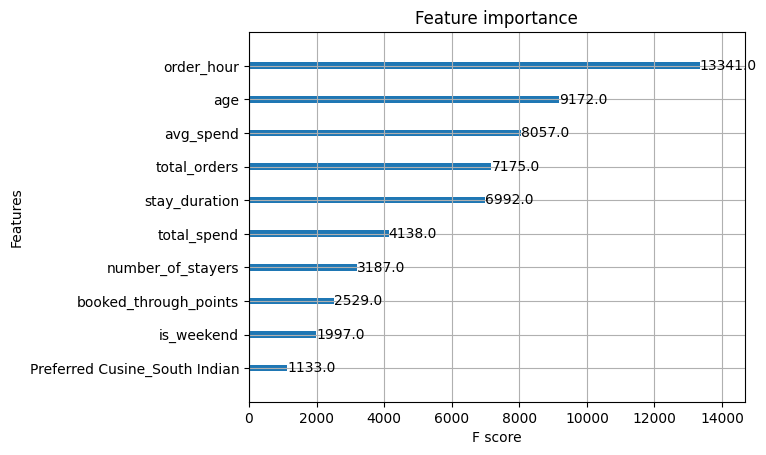

In [17]:
# Feature Importance
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': best_model.feature_importances_}).sort_values(by='Importance', ascending=False)
xgb.plot_importance(best_model, max_num_features=10)
plt.show()